In [1]:
import sys
#sys.path.insert(0, "../input/timm-efficientdet-pytorch")
#sys.path.insert(0, "../input/omegaconf")

import torch
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold, KFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
import torch.nn as nn
from glob import glob

SEED = 42
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [2]:
"""
marking = pd.read_csv('../input/global-wheat-detection/train.csv')

bboxs = np.stack(marking['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    marking[column] = bboxs[:,i]
marking.drop(columns=['bbox'], inplace=True)
"""
#marking = pd.DataFrame({"image_id":[os.path.splitext(i)[0] for i in os.listdir("/home/ubuntu/datasets/signate/fish/train_images")]})
annos = os.listdir("/home/ubuntu/datasets/signate/fish/train_annotations")
anno_path = "/home/ubuntu/datasets/signate/fish/train_annotations/"
import json
img_id = []
w = []

for anno in annos:
    #print(anno[:-5])
    n = 0
    with open(anno_path + anno) as f:
        l = json.load(f)["labels"]
        l_keys = l.keys()
        for k in l_keys:
            if k in ["Jumper School","Breezer School"]:

                n += len(l[k])
    #print(n)
    if not n == 0:
        img_id.append(anno[:-5])
            #for box in l[k]:
                #print(box)
    
marking = pd.DataFrame({"image_id":img_id})


#skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf = KFold(n_splits=5, shuffle=True, random_state=14)


df_folds = marking[['image_id']].copy()
#df_folds.loc[:, 'bbox_count'] = 1
#df_folds = df_folds.groupby('image_id').count()
#df_folds.loc[:, 'source'] = marking[['image_id', 'source']].groupby('image_id').min()['source']
#df_folds.loc[:, 'stratify_group'] = np.char.add(
#    df_folds['source'].values.astype(str),
#    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
#)
df_folds.loc[:, 'fold'] = 0
for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index)):
#for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

In [3]:
annos = os.listdir("/home/ubuntu/datasets/signate/fish/train_annotations")
anno_path = "/home/ubuntu/datasets/signate/fish/train_annotations/"
import json
img_id = []
w = []

for anno in annos:
    #print(anno[:-4])
    n = 0
    with open(anno_path + anno) as f:
        l = json.load(f)["labels"]
        l_keys = l.keys()
        for k in l_keys:
            if k in ["Jumper School","Breezer School"]:

                n += len(l[k])
    #print(n)
    if not n == 0:
        img_id.append(anno[:-4])
            #for box in l[k]:
                #print(box)
    
marking = pd.DataFrame({"image_id":img_id})


In [4]:
def get_train_transforms():
    return A.Compose(
        [
#            A.RandomSizedCrop(min_max_height=(800, 800), height=1024, width=1024, p=0.5),
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Resize(height=512, width=512, p=1),
            A.Cutout(num_holes=2, max_h_size=32, max_w_size=32, fill_value=0, p=0.5),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

In [5]:
TRAIN_ROOT_PATH = '../input/global-wheat-detection/train'
TRAIN_ROOT_PATH = "/home/ubuntu/datasets/signate/fish/train_images"
ANNO_ROOT_PATH = "/home/ubuntu/datasets/signate/fish/train_annotations/"


class DatasetRetriever(Dataset):

    def __init__(self, marking, image_ids, transforms=None, test=False):
        super().__init__()

        self.image_ids = image_ids
        self.marking = marking
        self.transforms = transforms
        self.test = test
    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        
        if self.test or random.random() > 0.0:
            image, boxes, labels = self.load_image_and_boxes(index)
        else:
            image, boxes = self.load_cutmix_image_and_boxes(index)

        # there is only one class
        #labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = torch.tensor(labels)
        target['image_id'] = torch.tensor([index])
        
        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                    break

        return image, target, image_id
    
    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        #print(image_id)
        image = cv2.imread(f'{TRAIN_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        #records = self.marking[self.marking['image_id'] == image_id]
        #boxes = records[['x', 'y', 'w', 'h']].values
        #boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        #boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        boxes = []
        labels = []
        label_id = ["Jumper School","Breezer School"]
        with open(ANNO_ROOT_PATH + image_id + ".json") as f:
            l = json.load(f)["labels"]
            l_keys = l.keys()
            for k in l_keys:
                if k in label_id:
                    for box in l[k]:
                        boxes.append(box)
                        labels.append(label_id.index(k) + 1)
        #print(labels)
        #print(boxes)
        return image, np.array(boxes), labels
    
    def load_cutmix_image_and_boxes(self, index, imsize=1024):
        """ 
        This implementation of cutmix author:  https://www.kaggle.com/nvnnghia 
        Refactoring and adaptation: https://www.kaggle.com/shonenkov
        """
        w, h = imsize, imsize
        s = imsize // 2
    
        xc, yc = [int(random.uniform(imsize * 0.25, imsize * 0.75)) for _ in range(2)]  # center x, y
        indexes = [index] + [random.randint(0, self.image_ids.shape[0] - 1) for _ in range(3)]

        result_image = np.full((imsize, imsize, 3), 1, dtype=np.float32)
        result_boxes = []
        
        for i, index in enumerate(indexes):
            image, boxes = self.load_image_and_boxes(index)
            if i == 0:
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
            result_image[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            padw = x1a - x1b
            padh = y1a - y1b

            boxes[:, 0] += padw
            boxes[:, 1] += padh
            boxes[:, 2] += padw
            boxes[:, 3] += padh

            result_boxes.append(boxes)

        result_boxes = np.concatenate(result_boxes, 0)
        np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
        result_boxes = result_boxes.astype(np.int32)
        result_boxes = result_boxes[np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)]
        return result_image, result_boxes

In [6]:
fold_number = 0

train_dataset = DatasetRetriever(
    #image_ids=df_folds[df_folds['fold'] != fold_number].index.values,
    image_ids=df_folds[df_folds['fold'] != fold_number].image_id.values,
    marking=marking,
    transforms=get_train_transforms(),
    test=False,
)

validation_dataset = DatasetRetriever(
    image_ids=df_folds[df_folds['fold'] == fold_number].image_id.values,
    marking=marking,
    transforms=get_valid_transforms(),
    test=True,
)

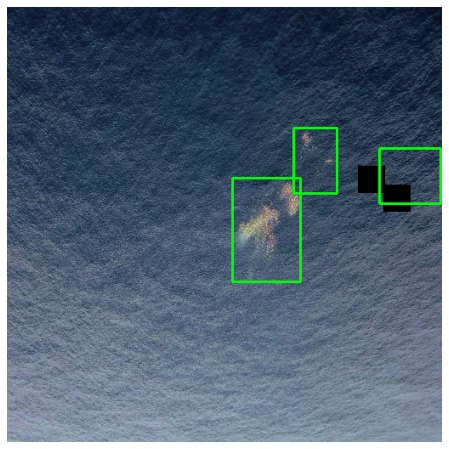

In [7]:
image, target, image_id = train_dataset[0]
boxes = target['boxes'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image);

In [8]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [9]:
import warnings

warnings.filterwarnings("ignore")

class Fitter:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'./{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10**5

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)

            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')

            t = time.time()
            summary_loss = self.validation(validation_loader)

            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                    os.remove(path)

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1

    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]

                #loss= self.model(images, {"bbox":boxes, "cls":labels})["loss"]
                target_res = {}
                target_res['bbox'] = boxes
                target_res['cls'] = labels 
                target_res["img_scale"] = torch.tensor([1.0] * batch_size, dtype=torch.float).to(self.device)
                target_res["img_size"] = torch.tensor([images[0].shape[-2:]] * batch_size, dtype=torch.float).to(self.device)

                outputs = self.model(images, target_res)
                #print(outputs["detections"])
                loss = outputs["loss"]
                summary_loss.update(loss.detach().item(), batch_size)


        return summary_loss

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )


            images = torch.stack(images)
            images = images.to(self.device).float()
            batch_size = images.shape[0]
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]
            
            self.optimizer.zero_grad()

            output = self.model(images, {"bbox":boxes, "cls":labels})
            loss = output["loss"]
            
            loss.backward()

            summary_loss.update(loss.detach().item(), batch_size)

            self.optimizer.step()

            if self.config.step_scheduler:
                self.scheduler.step()

        return summary_loss
    
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')


In [10]:
class TrainGlobalConfig:
    num_workers = 2
    batch_size = 1
    n_epochs = 40 # n_epochs = 40
    lr = 0.0002

    folder = 'effdet5-cutmix-augmix'

    # -------------------
    verbose = True
    verbose_step = 1
    # -------------------

    # --------------------
    step_scheduler = False  # do scheduler.step after optimizer.step
    validation_scheduler = True  # do scheduler.step after validation stage loss
    
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='min',
        factor=0.5,
        patience=1,
        verbose=False, 
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=1e-8,
        eps=1e-08
    )
    # --------------------

In [11]:
def collate_fn(batch):
    return tuple(zip(*batch))

def run_training():
    device = torch.device('cuda:0')
    net.to(device)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
        collate_fn=collate_fn,
    )
    val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
    fitter.fit(train_loader, val_loader)

In [12]:
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet



def get_net():
    config = get_efficientdet_config('tf_efficientdet_d5')
    config.num_classes = 2
    config.image_size = (512,512)
    #print(config)

    net = EfficientDet(config, pretrained_backbone=False)
    checkpoint = torch.load("effdet5-cutmix-augmix/best-checkpoint-002epoch.bin")
    net.load_state_dict(checkpoint['model_state_dict'])

    #checkpoint = torch.load('../input/efficientdet/efficientdet_d5-ef44aea8.pth')
    #net.load_state_dict(checkpoint)

    net.reset_head(num_classes=2)

    net.class_net = HeadNet(config, num_outputs=2)
    #net.class_net = HeadNet(config, num_outputs=2, norm_kwargs=dict(eps=.001, momentum=.01))

    return DetBenchTrain(net, config)

net = get_net()
#net = nn.DataParallel(net)

In [ ]:
run_training()

Fitter prepared. Device is cuda:0

2021-01-14T08:11:42.404350
LR: 0.0002


In [60]:
from effdet import DetBenchPredict
from effdet import create_model

def get_test_net():
    config = get_efficientdet_config('tf_efficientdet_d5')
    config.num_classes = 2
    config.image_size = (512,512)
    config.soft_nms = True
    #print(config)

    testnet = EfficientDet(config, pretrained_backbone=False)
    #checkpoint = torch.load('../input/efficientdet/efficientdet_d5-ef44aea8.pth')
    #net.load_state_dict(checkpoint)
    checkpoint = torch.load("effdet5-cutmix-augmix/best-checkpoint-002epoch.bin")
    testnet.load_state_dict(checkpoint['model_state_dict'])

    #testnet.reset_head(num_classes=2)

    #net.class_net = HeadNet(config, num_outputs=2)
    #net.class_net = HeadNet(config, num_outputs=2, norm_kwargs=dict(eps=.001, momentum=.01))
    #bench = create_model(
    #    model_name = "tf_efficientdet_d5",
    #    bench_task='predict',
    #    num_classes=2,
    #    pretrained=True,
        #redundant_bias=args.redundant_bias,
    #    soft_nms=False,
    #    checkpoint_path="effdet5-cutmix-augmix/last-checkpoint.bin",
        #checkpoint_ema=args.use_ema,
    #)
    
    
    return DetBenchPredict(testnet)

predict_net = get_test_net()



In [68]:
class submitDataset(Dataset):
    def __init__(self, src = "/home/ubuntu/datasets/signate/fish/test_images/", transform = False):
        super().__init__()
        self.src_path = src
        self.transforms = transform
        self.image_ids = os.listdir(self.src_path)

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]  
        image= self.load_image(image_id)
        #print(image.shape)
        sample = {
            #"img_scale":torch.tensor(image.shape[1]/image.shape[2]).float(),
            #"img_scale":torch.tensor(image.shape[1]/image.shape[0]).float(),
            "img_scale":torch.tensor(1.0).float(),
            #"img_size":torch.tensor([image.shape[0],image.shape[1]]).float()}
            "img_size":torch.tensor([512,512])}

        if self.transforms:
            image = self.transforms(**{'image': image})

        return torch.tensor(image["image"], dtype = torch.float), sample, image_id
    
    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image(self, image_id):
        image = cv2.imread(f'{self.src_path}/{image_id}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        return image
    
def get_test_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0, 
        )

sub_dataset = submitDataset(transform = get_test_transforms())

In [69]:
predict_net.eval()
predict_net.to('cuda:2')
print("")

In [237]:
def make_submit():
    outputs = []
    device = "cuda:2"

    for i, data in enumerate(sub_dataset):
        print("\r",i, end = "")
        img, sample = data
        #print(sample)
        with torch.no_grad():
            img = img.unsqueeze(0).to(device)
            sample = {"img_scale":sample["img_scale"].unsqueeze(0).to(device),
                     "img_size":sample["img_size"].unsqueeze(0).to(device)}
            #print(img.shape[-2:])
            output = predict_net(img, 
                                 #{"img_scale":None, "img_size": None}
                                 sample
                                #"img_scale":torch.tensor([1.0] * 1, dtype=torch.float).to(device),
                                # "img_size":torch.tensor([img.shape[-2:]] * 1, dtype=torch.float).to(device)}
                                #"img_scale":torch.tensor([1]).float(), 
                                #"img_size":torch.tensor([1000]).float()}
                                )
        if i == 5:
            break
        outputs.append(output)
    return outputs
    #predict_net(torch.tensor(sub_dataset[0]["image"], dtype = torch.float).unsqueeze(0),{"target":0})
    
out = make_submit()

(2160, 3840, 3)
 0{'img_scale': tensor(1.), 'img_size': tensor([512, 512])}
(2160, 3840, 3)
 1{'img_scale': tensor(1.), 'img_size': tensor([512, 512])}
(2160, 3840, 3)
 2{'img_scale': tensor(1.), 'img_size': tensor([512, 512])}
(2160, 3840, 3)
 3{'img_scale': tensor(1.), 'img_size': tensor([512, 512])}
(2160, 3840, 3)
 4{'img_scale': tensor(1.), 'img_size': tensor([512, 512])}
(2160, 3840, 3)
 5{'img_scale': tensor(1.), 'img_size': tensor([512, 512])}


In [70]:
out[2][:,:,4]

NameError: name 'out' is not defined

In [71]:
out[2]

NameError: name 'out' is not defined

In [240]:
out[2].shape

torch.Size([1, 100, 6])

In [19]:
image,sample = sub_dataset[2]
#print(sample)
#boxes = target['boxes'].cpu().numpy().astype(np.int32)
boxes = out[2][0][:, :4]
boxes = boxes[:10]

numpy_image = image.permute(1,2,0).cpu().numpy()
numpy_image = cv2.resize(numpy_image, (512, 512))
fig, ax = plt.subplots(1, 1, figsize=(10, 16))

for box in boxes:
    box = box.cpu().detach().numpy()
    #print(box)
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image)

NameError: name 'sub_dataset' is not defined

In [232]:
boxes[0]

tensor([ 87.3760,   0.0000, 641.3751,   9.7630], device='cuda:2')

In [100]:
test_loader = torch.utils.data.DataLoader(
    sub_dataset, 
   batch_size=TrainGlobalConfig.batch_size,
   num_workers=TrainGlobalConfig.num_workers,
   shuffle=False,
   sampler=SequentialSampler(validation_dataset),
    pin_memory=False,
    #collate_fn=collate_fn,
    drop_last = False
    )
def test_output(test_loader):
        net.to('cuda:2')

        net.eval()
        summary_loss = AverageMeter()
        t = time.time()
        output_detections = []
        ids = []
        device = "cuda:2"


        for step, (images, targets, image_ids) in enumerate(test_loader):
            print("\r", image_ids, end = "")

            with torch.no_grad():
                #print(images.shape)
                #images = torch.stack(images)
                images = images.unsqueeze(0)
                batch_size = images.shape[0]
                images = images.to(device).float().to(device)
                boxes = torch.tensor([[0,1,2,3]]).float().to(device)
                labels = torch.tensor([1]).to(device)

                #loss= self.model(images, {"bbox":boxes, "cls":labels})["loss"]
                target_res = {}
                target_res['bbox'] = boxes
                target_res['cls'] = labels 
                target_res["img_scale"] = torch.tensor([1.0] * batch_size, dtype=torch.float).to(device)
                target_res["img_size"] = torch.tensor([images[0].shape[-2:]] * batch_size, dtype=torch.float).to(device)

                outputs = net(images, target_res)
                output_detections.append(outputs["detections"])
                ids.append(image_ids)


        return output_detections, ids
o,ids = test_output(sub_dataset)

 test_1480.jpg

In [ ]:

["Jumper School","Breezer School"]

In [105]:
o[1]

          2.0000e+00]]], device='cuda:2')